# Assumption of Linear Regresion

## Anscombe's Quartet

Anscombe's Quartet is a collection of four datasets created by statistician Francis Anscombe in 1973. Each dataset has nearly identical simple statistical properties:

Similar means for x and y.

Similar variances.

Similar correlation coefficients.

Almost identical linear regression lines.

However, when you plot the datasets, they look very different from each other — showing patterns like clusters, curves, or outliers.

The main lesson from Anscombe's Quartet is:
Always visualize your data, not just rely on statistical summaries.
Simple statistics can be misleading without graphical analysis.

![Texto alternativo](../../images/assumptionOfLinearRegresion.png)

La regresión lineal es un método estadístico poderoso, pero para que sus resultados sean válidos y confiables, deben cumplirse ciertos supuestos:

1. Linealidad
La asunción de linealidad en la regresión lineal significa que existe una relación lineal entre la variable independiente (o independientes, si hay varias) y la variable dependiente. Es decir:

La relación entre 𝑋 y Y puede describirse como una línea recta (en el caso de una sola variable) o como un plano/hiperplano (en caso de múltiples variables). Si la relación no es lineal, las predicciones de la regresión lineal serán sesgadas y poco confiables.

Matemáticamente:

y= β0 + β1X + ϵ

ϵ es el error (residual).


2. Homocedasticidad
Teoría: La varianza de los errores debe ser constante a lo largo de todos los niveles de las variables independientes. Si la varianza cambia (heterocedasticidad), las estimaciones de significancia estadística pueden ser incorrectas.

3. Normalidad Multivariante
Teoría: Los errores/residuos deben seguir una distribución normal. Esto es especialmente importante para intervalos de confianza y pruebas de hipótesis.

4. Independencia
Teoría: Las observaciones deben ser independientes entre sí (no autocorrelacionadas). Esto es crucial en datos de series temporales donde los valores suelen estar correlacionados con sus valores pasados.

5. Ausencia de Multicolinealidad
Teoría: Las variables independientes no deben estar altamente correlacionadas entre sí. La multicolinealidad hace difícil determinar el efecto individual de cada variable.

6. Detección de Outliers (Extra)
Teoría: Aunque no es un supuesto estricto, los valores atípicos pueden tener un impacto desproporcionado en el modelo, distorsionando los resultados.

References:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# 1. Cargar y preparar los datos
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['progression'] = diabetes.target

print("=== DESCRIPCIÓN DEL DATASET ===")
print(diabetes.DESCR[:500] + "...")  # Mostrar solo parte de la descripción

# 2. Análisis de supuestos de regresión lineal

# A. Linealidad
print("\n\n=== 1. LINEALIDAD ===")
plt.figure(figsize=(15, 8))
for i, col in enumerate(diabetes.feature_names):
    plt.subplot(2, 5, i+1)
    sns.regplot(x=df[col], y=df['progression'], line_kws={'color': 'red'})
    plt.title(f"{col} vs Progresión")
plt.tight_layout()
plt.show()

print("\nEvaluación:")
print("- Se observa visualmente si existe relación lineal entre cada predictor y la variable respuesta")
print("- Variables como 'bmi' y 's5' muestran tendencias lineales claras")
print("- Algunas variables como 'sex' muestran poca relación lineal")

# B. Modelo de regresión
print("\n\n=== 2. MODELO DE REGRESIÓN ===")
X = sm.add_constant(df.drop('progression', axis=1))
y = df['progression']
model = sm.OLS(y, X).fit()
print(model.summary())

# C. Homocedasticidad
print("\n\n=== 3. HOMOCEDASTICIDAD ===")
predicted = model.predict(X)
residuals = y - predicted

plt.figure(figsize=(10, 6))
plt.scatter(predicted, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.show()

# Prueba Breusch-Pagan
_, pval, _, _ = sm.stats.diagnostic.het_breuschpagan(residuals, model.model.exog)
print(f"\nPrueba Breusch-Pagan - p-valor: {pval:.4f}")

print("\nEvaluación:")
if pval > 0.05:
    print("- Se cumple el supuesto (p > 0.05). Los residuos tienen varianza constante")
else:
    print("- NO se cumple el supuesto (p ≤ 0.05). Existe heterocedasticidad")
    print("- Solución posible: Transformar variables o usar modelos robustos")

# D. Normalidad de residuos
print("\n\n=== 4. NORMALIDAD DE RESIDUOS ===")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(residuals, plot=plt)
plt.title('QQ Plot')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribución de Residuos')

plt.tight_layout()
plt.show()

# Prueba Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)
print(f"\nPrueba Shapiro-Wilk - Estadístico: {shapiro_test[0]:.4f}, p-valor: {shapiro_test[1]:.4f}")

print("\nEvaluación:")
if shapiro_test[1] > 0.05:
    print("- Se cumple el supuesto (p > 0.05). Los residuos siguen distribución normal")
else:
    print("- NO se cumple el supuesto (p ≤ 0.05). Los residuos no son normales")
    print("- Solución posible: Transformación de variables o métodos no paramétricos")

# E. Independencia (Autocorrelación)
print("\n\n=== 5. INDEPENDENCIA DE RESIDUOS ===")
durbin_watson = sm.stats.durbin_watson(residuals)
print(f"Estadístico Durbin-Watson: {durbin_watson:.4f}")

print("\nEvaluación:")
if 1.5 < durbin_watson < 2.5:
    print("- Se cumple el supuesto. No hay autocorrelación significativa")
else:
    print("- Posible autocorrelación. Valor fuera del rango ideal [1.5, 2.5]")
    print("- Solución posible: Modelos ARIMA o considerar estructura temporal")

# F. Multicolinealidad
print("\n\n=== 6. MULTICOLINEALIDAD ===")
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

print("\nEvaluación:")
high_vif = vif_data[vif_data['VIF'] > 5]
if len(high_vif) == 0:
    print("- No hay multicolinealidad problemática (VIF < 5 para todas las variables)")
else:
    print(f"- Variables con posible multicolinealidad (VIF > 5):")
    print(high_vif)
    print("- Solución posible: Eliminar variables correlacionadas o usar PCA")

# G. Outliers
print("\n\n=== 7. DETECCIÓN DE OUTLIERS ===")
std_residuals = residuals / np.std(residuals)
outliers = np.abs(std_residuals) > 3

plt.figure(figsize=(10, 6))
plt.scatter(predicted, std_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=3, color='g', linestyle='--')
plt.axhline(y=-3, color='g', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos Estandarizados')
plt.title('Outliers (> 3 desviaciones estándar)')
plt.show()

print(f"\nOutliers detectados: {outliers.sum()} ({outliers.mean()*100:.2f}%)")

print("\nEvaluación:")
if outliers.sum() == 0:
    print("- No se detectaron outliers significativos")
else:
    print("- Se detectaron posibles outliers que podrían afectar el modelo")
    print("- Solución posible: Investigar estos casos o usar métodos robustos")

print("\n=== RESUMEN FINAL DE SUPUESTOS ===")
print("1. Linealidad: Parcialmente cumplida (revisar relaciones individuales)")
print(f"2. Homocedasticidad: {'Cumplida' if pval > 0.05 else 'No cumplida'}")
print(f"3. Normalidad residuos: {'Cumplida' if shapiro_test[1] > 0.05 else 'No cumplida'}")
print(f"4. Independencia residuos: {'Cumplida' if 1.5 < durbin_watson < 2.5 else 'Revisar'}")
print(f"5. Multicolinealidad: {'Baja' if len(high_vif) == 0 else 'Presente'}")
print(f"6. Outliers: {'Pocos' if outliers.sum() < 5 else 'Numerosos'}")


## Linealidad

La asunción de linealidad en la regresión lineal significa que existe una relación lineal entre la variable independiente (o independientes, si hay varias) y la variable dependiente. Es decir:

La relación entre 𝑋 y Y puede describirse como una línea recta (en el caso de una sola variable) o como un plano/hiperplano (en caso de múltiples variables). Si la relación no es lineal, las predicciones de la regresión lineal serán sesgadas y poco confiables.

Matemáticamente:

y= β0 + β1X + ϵ

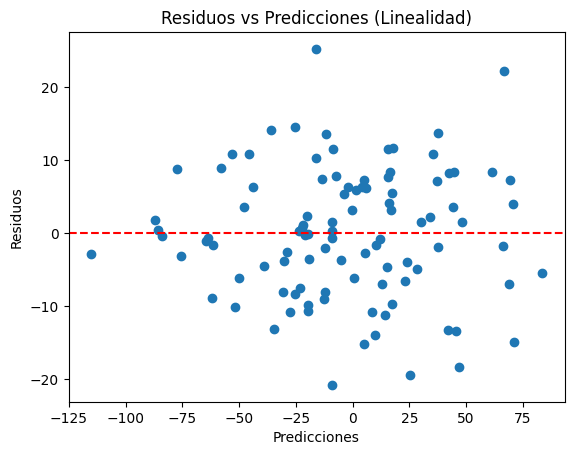

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

# Creamos datos que cumplen linealidad
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

# Creamos el modelo
model = LinearRegression()
model.fit(X, y)

# Predicciones
y_pred = model.predict(X)

# Residuales
residuals = y - y_pred

# Gráfica de residuos vs predicciones
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones (Linealidad)')
plt.show()

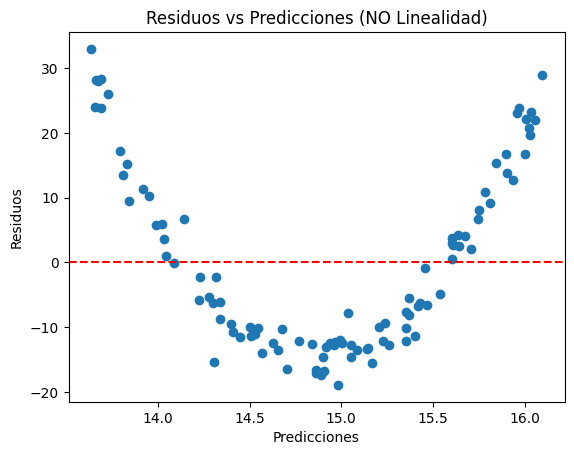

In [15]:
# Example 2: Datos con no linealidad

# Datos con una relación cuadrática
X = np.random.uniform(-3, 3, 100).reshape(-1, 1)
y = 5 * (X**2) + np.random.normal(0, 3, 100).reshape(-1, 1)

# Modelo lineal
model = LinearRegression()
model.fit(X, y)

# Predicciones
y_pred = model.predict(X)

# Residuales
residuals = y - y_pred

# Gráfica de residuos vs predicciones
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones (NO Linealidad)')
plt.show()

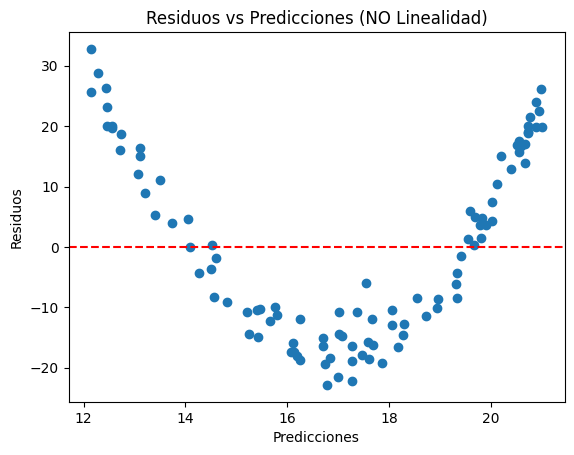

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Example: Datos sin linealidad

# Ahora generamos datos no lineales:

# Datos con una relación cuadrática
X = np.random.uniform(-3, 3, 100).reshape(-1, 1)
y = 5 * (X**2) + np.random.normal(0, 3, 100).reshape(-1, 1)

# Modelo lineal
model = LinearRegression()
model.fit(X, y)

# Predicciones
y_pred = model.predict(X)

# Residuales
residuals = y - y_pred

# Gráfica de residuos vs predicciones
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones (NO Linealidad)')
plt.show()



## Validación de las Suposiciones de Regresión Lineal: Homocedasticidad

La homocedasticidad es una de las suposiciones fundamentales de la regresión lineal. Vamos a explorarla tanto teóricamente como con ejemplos prácticos.
¿Qué es la homocedasticidad?
Definición teórica: La homocedasticidad significa que la varianza de los errores (residuos) es constante a lo largo de todos los valores de las variables independientes. En otras palabras, la dispersión de los residuos debe ser similar para todos los valores predichos por el modelo.
Cuando esta condición no se cumple, tenemos heterocedasticidad, lo que puede llevar a:

Estimaciones ineficientes de los coeficientes (aunque siguen siendo insesgadas)
Errores estándar incorrectos, lo que afecta las pruebas de hipótesis y los intervalos de confianza

### Cómo validar la homocedasticidad en la práctica

Método 1: Gráfico de residuos vs valores ajustados

Ejemplo práctico:
Supongamos que tenemos un modelo que predice el precio de viviendas basado en su superficie.

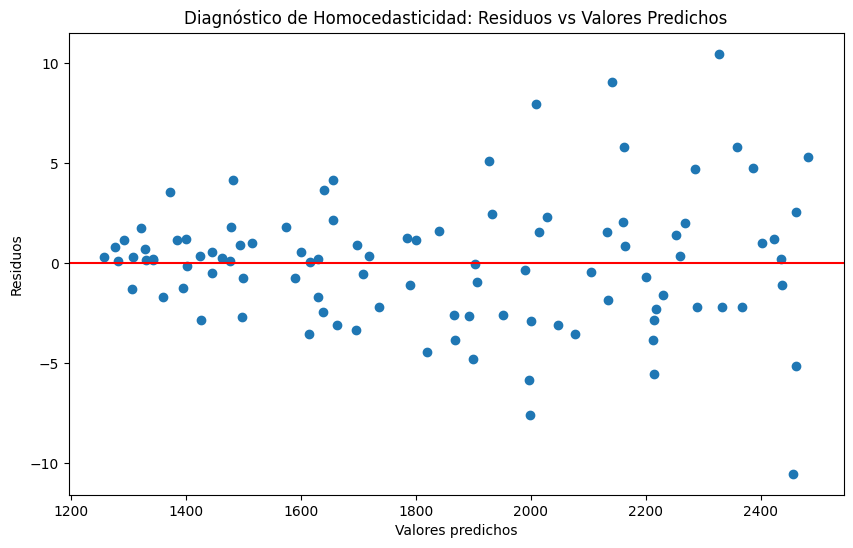

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Crear datos de ejemplo
np.random.seed(42)
superficie = np.random.uniform(50, 300, 100)
# Simulamos heterocedasticidad: mayor superficie, mayor variabilidad en precios
error = np.random.normal(0, superficie/50, 100)
precio = 1000 + 5 * superficie + error

# Crear DataFrame
datos = pd.DataFrame({'superficie': superficie, 'precio': precio})

# Ajustar modelo
X = sm.add_constant(datos['superficie'])
modelo = sm.OLS(datos['precio'], X).fit()

# Obtener residuos y valores ajustados
datos['residuos'] = modelo.resid
datos['predicciones'] = modelo.predict()

# Gráfico de residuos vs valores ajustados
plt.figure(figsize=(10, 6))
plt.scatter(datos['predicciones'], datos['residuos'])
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Valores predichos')
plt.ylabel('Residuos')
plt.title('Diagnóstico de Homocedasticidad: Residuos vs Valores Predichos')
plt.show()

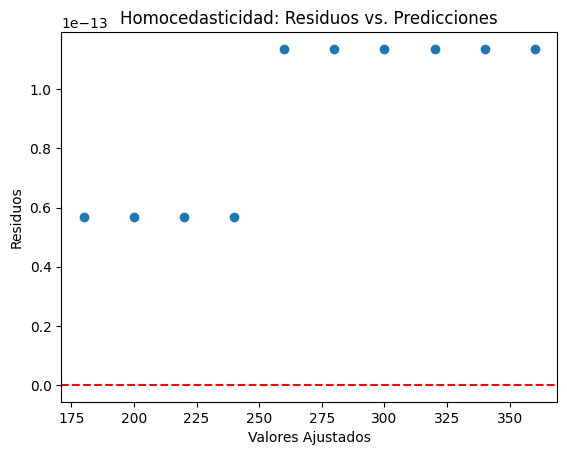

: 

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Datos de ejemplo (simulados)
m2 = [70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
precio = [180, 200, 220, 240, 260, 280, 300, 320, 340, 360]  # Relación lineal perfecta (para simplificar)

# Ajustar modelo
X = sm.add_constant(m2)  # Añadir intercepto
modelo = sm.OLS(precio, X).fit()
residuos = modelo.resid

plt.scatter(modelo.fittedvalues, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valores Ajustados")
plt.ylabel("Residuos")
plt.title("Homocedasticidad: Residuos vs. Predicciones")
plt.show()